In [ ]:
# IMPORT CÁC THƯ VIỆN
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
# TẢI DỮ LIỆU
# transform.ToTensor() giúp chuyển ảnh từ [0,255] → [0,1] và sang tensor PyTorch
transform = transforms.ToTensor()

# Tải tập train
train_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
#Tải tập test
test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


In [ ]:
#Tạo DataLoader (chia dữ liệu thành các batch nhỏ)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)


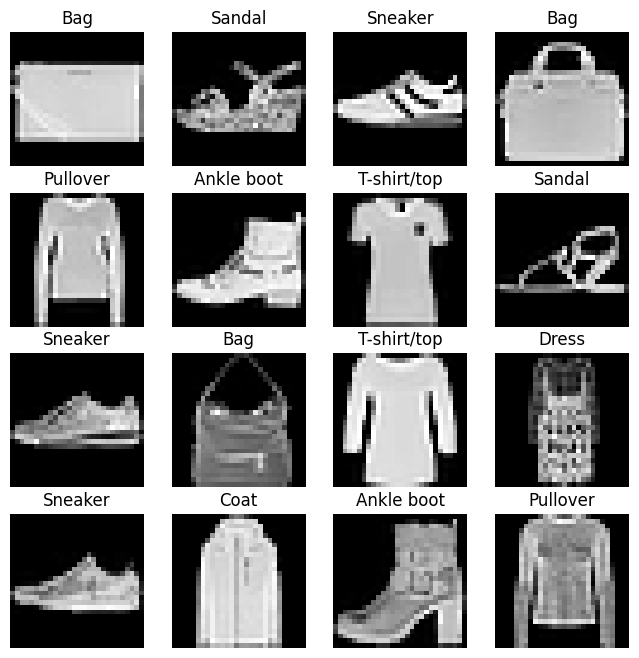

In [5]:
#Hiện thị dữ liệu theo mẫu
# labels_map giúp ánh xạ chỉ số (0–9) sang tên loại quần áo cụ thể
labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
# Hiển thị 16 ảnh ngẫu nhiên từ tập train
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [ ]:
from torch import nn
# Định nghĩa lớp mạng nơ-ron cho bài toán phân loại FashionMNIST
class FashionNN(nn.Module):
    def __init__(self):
        # Gọi hàm khởi tạo của lớp cha nn.Module để kế thừa đầy đủ chức năng
        super().__init__()
         # Layer đầu tiên: chuyển ảnh 2D (28x28) thành vector 1D (784 phần tử)
        # vì các lớp Linear chỉ nhận đầu vào là vector phẳng.
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

# Hàm forward định nghĩa cách dữ liệu đi qua các tầng
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

# Khởi tạo một đối tượng mô hình
model = FashionNN()
# In cấu trúc mô hình để kiểm tra

print(model)


FashionNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
import torch.optim as optim
# Hàm mất mát(LOSS FUNCTION) 
loss_fn = nn.CrossEntropyLoss()
#Bộ tối ưu hóa
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
epochs = 5  # bạn có thể thử tăng lên 10 hoặc 20

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Reset gradient
        optimizer.zero_grad()

        # Forward
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward
        loss.backward()

        # Optimize
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5] - Loss: 0.5600
Epoch [2/5] - Loss: 0.3940
Epoch [3/5] - Loss: 0.3549
Epoch [4/5] - Loss: 0.3326
Epoch [5/5] - Loss: 0.3107


In [ ]:
#Kiểm tra xem mô hình dự đoán đúng bao nhiêu phần trăm trên tập test
correct = 0
total = 0
with torch.no_grad():  # không cần tính gradient khi test
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")


Accuracy: 87.55%


In [ ]:
torch.save(model.state_dict(), 'fashion_model.pth')
#Lưu trọng số của mô hình
# Chỉ lưu trọng số, không lưu cấu trúc phức tạp(class)

In [ ]:
#Tạo lại một instance của mô hình với cùng kiến trúc
model = FashionNN()
# Nạp lại trọng số đã lưu trước đó vào mô hình mới
model.load_state_dict(torch.load('fashion_model.pth'))
#Chuyển mô hình qua chế độ đánh giá
model.eval()


FashionNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

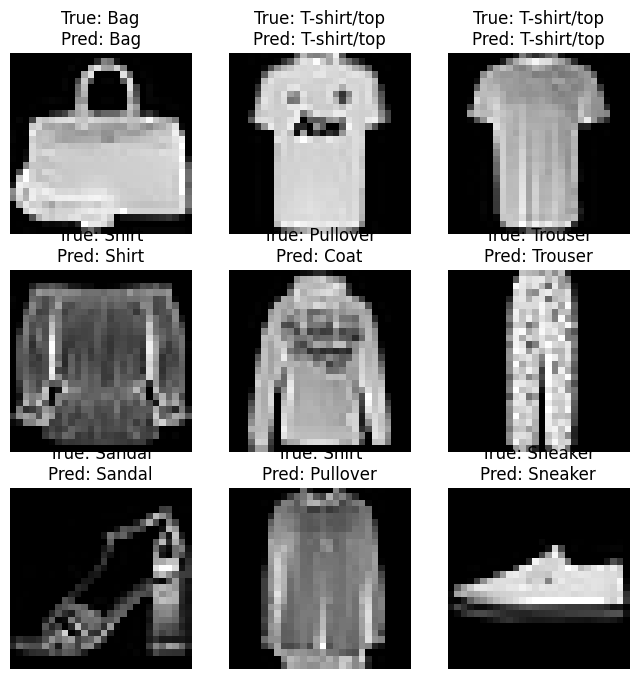

In [ ]:
#Hiện thị vài ảnh test cùng nhãn thật và nhãn dự đoán
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
model.eval()

with torch.no_grad():
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(test_data), size=(1,)).item()
        img, label = test_data[sample_idx]
        output = model(img.unsqueeze(0))
        pred = output.argmax(1).item()
        figure.add_subplot(rows, cols, i)
        plt.title(f"True: {labels_map[label]}\nPred: {labels_map[pred]}")
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
plt.show()



In [ ]:
#Thêm một danh sách loss_values để lưu loss trung bình của từng epoch

#Số lần duyệt qua toàn bộ dữ liệu train
epochs = 10  # có thể điều chỉnh
#Danh sách lưu loss trung bình của từng epoch
loss_values = []

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


Epoch [1/10] - Loss: 0.2859
Epoch [2/10] - Loss: 0.2858
Epoch [3/10] - Loss: 0.2860
Epoch [4/10] - Loss: 0.2859
Epoch [5/10] - Loss: 0.2859
Epoch [6/10] - Loss: 0.2858
Epoch [7/10] - Loss: 0.2857
Epoch [8/10] - Loss: 0.2859
Epoch [9/10] - Loss: 0.2858
Epoch [10/10] - Loss: 0.2858


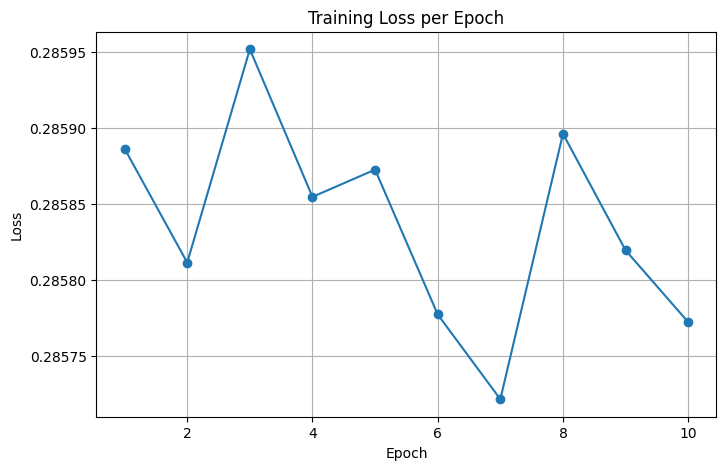

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), loss_values, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
# Biểu đồ dao động mạnh --> cần giảm learning rate và tăng batch size